# Import and setup

In [1]:
!which python

/home/gkoren2/miniconda3/envs/difsrx/bin/python


In [2]:
import os
import sys
difsr_root= os.path.dirname(os.getcwd())
sys.path.insert(1, difsr_root)
sys.path

['/home/gkoren2/work/git/gkoren2/DIF-SR/notebooks',
 '/home/gkoren2/work/git/gkoren2/DIF-SR',
 '/home/gkoren2/study/git/guyk1971/d3rlpy',
 '/home/gkoren2/miniconda3/envs/difsrx/lib/python39.zip',
 '/home/gkoren2/miniconda3/envs/difsrx/lib/python3.9',
 '/home/gkoren2/miniconda3/envs/difsrx/lib/python3.9/lib-dynload',
 '',
 '/home/gkoren2/miniconda3/envs/difsrx/lib/python3.9/site-packages',
 '/home/gkoren2/work/git/clones/transformers/src']

In [3]:
import os 
import pandas as pd
import numpy as np
from datetime import datetime
from recbole.config import Config
from recbole.data import create_dataset
from recbole.data.utils import get_dataloader
from recbole.utils import init_logger, init_seed, get_model, get_trainer, set_color
import matplotlib.pyplot as plt
from copy import copy

In [4]:
dataset_root = os.path.abspath('../dataset')
# os.listdir(dataset_root)
os.listdir('../dataset/')

['Steam',
 'Amazon_Sports_and_Outdoors',
 'Amazon_Beauty',
 'Amazon_Toys_and_Games',
 'yelp']

In [5]:
from dataclasses import dataclass

@dataclass
class Arguments:
    model:str = 'SASRecDX2'
    dataset:str = 'yelp'
    config_files:str = None





# Yelp

In [6]:
dataset_path=os.path.join(dataset_root,'yelp')
os.listdir(dataset_path)

['yelp.item', 'yelp.user', 'yelp.zip', 'yelp.inter', 'README.md']

## EDA

### Reading the dataset using recbole

In [ ]:
# reading the dataset through the recbole framework
args=Arguments(dataset="yelp",config_files=os.path.join(difsr_root,'configs/yelp_cat_L1.yaml'))
config_file_list = args.config_files.strip().split(' ') if args.config_files else None
config = Config(model=args.model, dataset=f'{args.dataset}', config_file_list=config_file_list)
config.final_config_dict['data_path'] = os.path.join(difsr_root,config.final_config_dict['data_path'])
config.final_config_dict

In [ ]:
dataset = create_dataset(config)
dataset

In [ ]:
dataset.item_feat.head()

In [ ]:
# print the list of columns that can be considered as features
dataset.field2token_id.keys()

In [ ]:
dataset.item_feat['categories'].loc[0].dtype

### read item data

In [ ]:
ydf=pd.read_csv(os.path.join(dataset_path,'yelp.item'),sep='\t')
ydf.head()

In [ ]:
# check how many non-Nan values are there in each column
ydf.count()/len(ydf)

### read original data
reading the data from the Yelp dataset, before it has been preprocessed by recbole. the dataset was downloaded from Kaggle (version 4)


In [ ]:
import json
yelp_orig_path='/home/guy/sd1tb/datasets/yelp'
os.listdir(yelp_orig_path)


In [ ]:
#read json file to dataframe
def read_json_to_df(path):
    with open(path) as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame.from_dict(data)

yelp_review=read_json_to_df(os.path.join(yelp_orig_path,'yelp_academic_dataset_review.json'))
yelp_review.head()

In [ ]:
# group by reviews of user u by day of review and count the number of reviews
u.groupby(u['date'].dt.date).count()['review_id']

In [ ]:
# find how many users have more than 100 reviews
len(yelp_review.groupby('user_id').count()['review_id'][yelp_review.groupby('user_id').count()['review_id']>100])

In [ ]:
yelp_review['user_id'].value_counts()

## running predictions

In [7]:
import torch
torch.cuda.is_available()



True

In [8]:
# reading the dataset through the recbole framework
# args=Arguments(dataset="yelp",config_files=os.path.join(difsr_root,'configs/yelp_cat_L1.yaml'))
# args=Arguments(dataset="yelp",config_files=os.path.join(difsr_root,'configs/yelp_cat_city_L1.yaml'))
args=Arguments(dataset="yelp",config_files=os.path.join(difsr_root,'configs/exp4/yelp_cat_city.yaml'))
# args=Arguments(dataset="yelp",config_files=os.path.join(difsr_root,'configs/exp5/yelp_cat_city.yaml'))
# make sure the model path is aligned with the configuration
model_path=os.path.join(difsr_root,'saved/yelp_cat_city')   # goes with configs/yelp_cat_city.yaml
# model_path=os.path.join(difsr_root,'saved/exp5')  # goes with configs/exp5/yelp_cat_city.yaml

config_file_list = args.config_files.strip().split(' ') if args.config_files else None
config = Config(model=args.model, dataset=f'{args.dataset}', config_file_list=config_file_list)
config.final_config_dict['data_path'] = os.path.join(difsr_root,config.final_config_dict['data_path'])
config.final_config_dict

{'gpu_id': 0,
 'use_gpu': True,
 'seed': 212,
 'state': 'INFO',
 'reproducibility': True,
 'data_path': '/home/gkoren2/work/git/gkoren2/DIF-SR/dataset/yelp',
 'checkpoint_dir': '/export/work/gkoren2/temp/difsr/exp4/yelp_cat_city',
 'show_progress': True,
 'save_dataset': False,
 'save_dataloaders': False,
 'epochs': 150,
 'train_batch_size': 2048,
 'learner': 'adam',
 'learning_rate': 0.0001,
 'neg_sampling': None,
 'eval_step': 2,
 'stopping_step': 10,
 'clip_grad_norm': None,
 'weight_decay': 0.0,
 'multi_gpus': False,
 'eval_args': {'split': {'LS': 'valid_and_test'},
  'group_by': 'user',
  'order': 'TO',
  'mode': 'full'},
 'repeatable': True,
 'metrics': ['Recall', 'NDCG'],
 'topk': [3, 5, 10, 20],
 'valid_metric': 'Recall@10',
 'valid_metric_bigger': True,
 'eval_batch_size': 256,
 'loss_decimal_place': 4,
 'metric_decimal_place': 4,
 'field_separator': '\t',
 'seq_separator': ' ',
 'USER_ID_FIELD': 'user_id',
 'ITEM_ID_FIELD': 'business_id',
 'RATING_FIELD': 'stars',
 'TIME_FIEL

In [9]:
ITEM_ID = config['ITEM_ID_FIELD']
ITEM_SEQ = ITEM_ID + config['LIST_SUFFIX']
ITEM_SEQ_LEN = config['ITEM_LIST_LENGTH_FIELD']

In [10]:
# create a dataset of type SequentialDataset
dataset = create_dataset(config)
dataset

yelp
The number of users: 30500
Average actions of users: 10.399750811502017
The number of items: 20069
Average actions of items: 15.805361769982062
The number of inters: 317182
The sparsity of the dataset: 99.94818172387231%
Remain Fields: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'date', 'item_name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'item_stars', 'item_review_count', 'is_open', 'categories']

### Manual prediction

In [ ]:
built_datasets = dataset.build()
train_dataset, valid_dataset, test_dataset = built_datasets
test_dataset

In [ ]:
#create an instance of the model
model = get_model(config['model'])(config, dataset).to(config['device'])
model 

In [ ]:
# attn_blocks = list(dict(model.trm_encoder.layer.named_children()).values())
# print(len(attn_blocks))
# attn_blocks[0]

In [ ]:
# set model path
# model_path=os.path.join(difsr_root,'saved/yelp_cat_city')
os.listdir(model_path)


In [ ]:
model_file_name=os.path.join(model_path,'SASRecD-Apr-09-2023_e150.pth')

# load the model
model_file = torch.load(model_file_name)
model.load_state_dict(model_file['state_dict'])
model.load_other_parameter(model_file.get('other_parameter'))
print('Loading model structure and parameters from {}'.format(model_file))
model.eval()


In [ ]:
idx=13
n_inter=1 # number of interactions to sample
interaction = test_dataset[idx:idx+n_inter]
pos_i = interaction[ITEM_ID]
interaction

In [ ]:
# interaction.categories
print(interaction.review_id_list)
print(interaction.business_id_list)
print(interaction.stars_list)
print(interaction.categories)

In [ ]:
# to get the embedding of the predicted item
item_seq = interaction[ITEM_SEQ].to(config['device'])
item_seq_len = interaction[ITEM_SEQ_LEN].to(config['device'])
gt_item = interaction[ITEM_ID]
item_embeddings = model.item_embedding.weight
seq_output=model(item_seq, item_seq_len)
scores = torch.matmul(seq_output, item_embeddings.transpose(0, 1))  # [B, item_num]

In [ ]:
# scores = model.full_sort_predict(interaction)
topk=20
topk_scores, topk_items = torch.topk(scores, topk)
print(topk_items)

### Interpret prediction
following the method from Hila's paper

In [11]:
# for debug - running all the necessary cells if not run as part of the Manual prediction
built_datasets = dataset.build()
train_dataset, valid_dataset, test_dataset = built_datasets
model = get_model(config['model'])(config, dataset).to(config['device'])

model_path=os.path.join(difsr_root,'saved/yelp_cat_city')
model_file_name=os.path.join(model_path,'SASRecD-Apr-09-2023_e150.pth')

# model_path=os.path.join(difsr_root,'saved/exp5')
# model_file_name=os.path.join(model_path,'SASRecDX2-May-09-2023_18-04-57.pth')       # disabling the attribute predictor by 'not' 
# model_file_name=os.path.join(model_path,'SASRecDX2-May-09-2023_20-44-58.pth')       # in addition, lamda=0


# load the model
model_file = torch.load(model_file_name)
model.load_state_dict(model_file['state_dict'])
model.load_other_parameter(model_file.get('other_parameter'))
print('Loading model structure and parameters from {}'.format(model_file))
model.eval()

Loading model structure and parameters from {'config': 
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 1212
state = INFO
reproducibility = True
data_path = dataset/yelp
show_progress = True
save_dataset = False
save_dataloaders = False
benchmark_filename = None

Training Hyper Parameters:
checkpoint_dir = /export/work/gkoren2/temp/difsr/exp4/yelp_cat_city
epochs = 150
train_batch_size = 2048
learner = adam
learning_rate = 0.0001
eval_step = 2
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'LS': 'valid_and_test'}, 'group_by': 'user', 'order': 'TO', 'mode': 'full'}
metrics = ['Recall', 'NDCG']
topk = [3, 5, 10, 20]
valid_metric = Recall@10
valid_metric_bigger = True
eval_batch_size = 256
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq_separator =  
USER_ID_FIELD = user_id
ITEM_ID_FIELD = business_id
RATING_FIELD = stars
TIME_FIELD = date
seq_len = None
LABEL_FI

SASRecDX2(
  (item_embedding): Embedding(20069, 256, padding_idx=0)
  (position_embedding): Embedding(50, 256)
  (feature_embed_layer_list): ModuleList(
    (0): FeatureSeqEmbLayer()
    (1): FeatureSeqEmbLayer()
  )
  (trm_encoder): DIFTransformerEncoder(
    (layer): ModuleList(
      (0): DIFTransformerLayer(
        (multi_head_attention): DIFMultiHeadAttention(
          (query): Linear(in_features=256, out_features=256, bias=True)
          (key): Linear(in_features=256, out_features=256, bias=True)
          (value): Linear(in_features=256, out_features=256, bias=True)
          (query_p): Linear(in_features=256, out_features=256, bias=True)
          (key_p): Linear(in_features=256, out_features=256, bias=True)
          (query_layers): ModuleList(
            (0): Linear(in_features=64, out_features=64, bias=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
          )
          (key_layers): ModuleList(
            (0): Linear(in_features=64, out_featu

In [ ]:
len(test_dataset)

In [49]:
# idx=113 # good example
idx=13190

n_inter=1 # number of interactions to sample
interaction = test_dataset[idx:idx+n_inter]
# interaction = train_dataset[idx:idx+n_inter]

item_seq_len = interaction[ITEM_SEQ_LEN]
pos_i = interaction[ITEM_ID]
print(f'sequence length: {item_seq_len.numpy()[0]}')
print(f'ground truth next item: {pos_i.numpy()[0]}')
print(f'the interaction fields: \n {interaction}')  # batch size is given by interaction.length 


sequence length: 23
ground truth next item: 2991
the interaction fields: 
 The batch_size of interaction: 1
    review_id, torch.Size([1]), cpu, torch.int64
    user_id, torch.Size([1]), cpu, torch.int64
    business_id, torch.Size([1]), cpu, torch.int64
    stars, torch.Size([1]), cpu, torch.float32
    useful, torch.Size([1]), cpu, torch.float32
    funny, torch.Size([1]), cpu, torch.float32
    cool, torch.Size([1]), cpu, torch.float32
    date, torch.Size([1]), cpu, torch.float32
    item_length, torch.Size([1]), cpu, torch.int64
    review_id_list, torch.Size([1, 50]), cpu, torch.int64
    business_id_list, torch.Size([1, 50]), cpu, torch.int64
    stars_list, torch.Size([1, 50]), cpu, torch.float64
    useful_list, torch.Size([1, 50]), cpu, torch.float64
    funny_list, torch.Size([1, 50]), cpu, torch.float64
    cool_list, torch.Size([1, 50]), cpu, torch.float64
    date_list, torch.Size([1, 50]), cpu, torch.float64
    item_name, torch.Size([1, 12]), cpu, torch.int64
    addres

In [50]:
scores, expl = model.interpret(interaction,start_layer=0)
rel_map = model.relevancy_map
expl.shape,rel_map.shape

(torch.Size([1, 1, 50]), torch.Size([1, 50, 50]))

#### Debug the gradients
The following cell is to debug the gradients/

In [ ]:
from tqdm import tqdm_notebook as tqdm

def check_grads(interaction,layer=0, index=None):
        device = model.device
        item_seq = interaction[model.ITEM_SEQ].to(device)
        batch_size = interaction.length
        item_seq_len = interaction[model.ITEM_SEQ_LEN].to(device)
        seq_output = model(item_seq, item_seq_len)
        item_embeddings = model.item_embedding.weight
        scores = torch.matmul(seq_output, item_embeddings.transpose(0, 1))  # [B, item_num]
        scores = scores.softmax(dim=-1)
        if index is None:
            index = scores.argmax(dim=-1).detach().cpu().numpy()

        one_hot = np.zeros((scores.shape[0], scores.shape[1]), dtype=np.float32)
        one_hot[torch.arange(scores.shape[0]), index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda(device) * scores,dim=-1)
        model.zero_grad()        # why do we need it ? 

        attn_blocks = list(dict(model.trm_encoder.layer.named_children()).values())
        blk=attn_blocks[layer]
        S=interaction[model.ITEM_SEQ_LEN]
        result={}
        for i in range(batch_size):
            grad = -torch.autograd.grad(one_hot[i], [blk.multi_head_attention.attention_probs], retain_graph=True)[0].detach()
            cam = blk.multi_head_attention.attention_probs.detach()
            neg_grad = (grad<0).sum(dim=1)[:,S[i]-1].cpu()
            neg_cam = (cam<0).sum(dim=1)[:,S[i]-1].cpu()
            result.update({S[i]:(neg_grad[i],neg_cam[i])})

        return result
        


In [ ]:
check_grads(interaction,layer=0)

In [ ]:
bs=10
res=dict()
for b in tqdm(range(len(test_dataset)//bs)):
    interactions = test_dataset[b*bs:b*bs+bs]
    res.update(check_grads(interactions,layer=-1))

res

#### view attention maps
view attention maps from the model

In [51]:
# attention mask
attn_mask = model.extended_attention_mask.detach().cpu().squeeze(0)  # [1,L,L]

# accessing the attributes attention scores of the first layer [b,h,L,p,L] where p is the number of attributes
attr_attn_scores = model.trm_encoder.layer[0].multi_head_attention.attribute_attention_table.detach().cpu().permute(0,3,1,2,4).squeeze(0)    #[p,h,L,L]

# accessing the item ID attention scores of the first layer: [b,h,L,L]
item_attn_scores = model.trm_encoder.layer[0].multi_head_attention.item_attention_scores.detach().cpu().squeeze(0)     #[h,L,L]

# accessing the position attention scores of the first layer: [b,h,L,L]
pos_attn_scores = model.trm_encoder.layer[0].multi_head_attention.pos_scores.detach().cpu().squeeze(0)    #[h,L,L]

# attention probs - after fusion of attributes, score and item ID attention and doing softmax normalization
attn_probs = model.trm_encoder.layer[0].multi_head_attention.attention_probs.detach().cpu().squeeze(0)   #[h,L,L]

# relevancy map - an aggregated view of the attention map
# scores, expl = model.interpret(interaction,start_layer=0) 
rel_map = model.relevancy_map.detach().cpu().squeeze(0)



In [52]:
attn_mask.shape, attr_attn_scores.shape, item_attn_scores.shape, pos_attn_scores.shape, attn_probs.shape, rel_map.shape

(torch.Size([1, 50, 50]),
 torch.Size([2, 8, 50, 50]),
 torch.Size([8, 50, 50]),
 torch.Size([8, 50, 50]),
 torch.Size([8, 50, 50]),
 torch.Size([50, 50]))

In [23]:
def attn_view(attention_weights,attention_mask,item_seq_len,norm_to_probs=True):
    # Reshape attention weights tensor to have shape (num_heads, seq_length, seq_length)
    if norm_to_probs:
        attention_weights = attention_weights + attention_mask
        attention_weights = torch.nn.Softmax(dim=-1)(attention_weights)
    attention_weights = attention_weights.numpy()[:,:item_seq_len,:item_seq_len]
    num_heads = attention_weights.shape[0]
    attention_weights = np.transpose(attention_weights, (1, 2, 0))  # switch to (seq_length, seq_length, num_heads)

    # Normalize each head's attention weights across all tokens in sequence
    for h in range(num_heads):
        attention_weights[:, :, h] = attention_weights[:, :, h] / np.sum(attention_weights[:, :, h], axis=1, keepdims=True)

    # Visualize attention maps as heatmaps or matrices
    fig, axs = plt.subplots(nrows=num_heads, ncols=1, figsize=(10, 20))
    for h in range(num_heads):
        im=axs[h].imshow(attention_weights[:, :, h], cmap='viridis', interpolation='nearest')
        axs[h].set_title('Head {}'.format(h+1))
        # add colorbar to each plot
        fig.colorbar(im, ax=axs[h])
    plt.show()

In [ ]:
attn_view(item_attn_scores,attn_mask,item_seq_len)


In [ ]:
attn_view(attr_attn_scores[1],attn_mask,item_seq_len)

In [ ]:
attn_view(pos_attn_scores,attn_mask,item_seq_len)

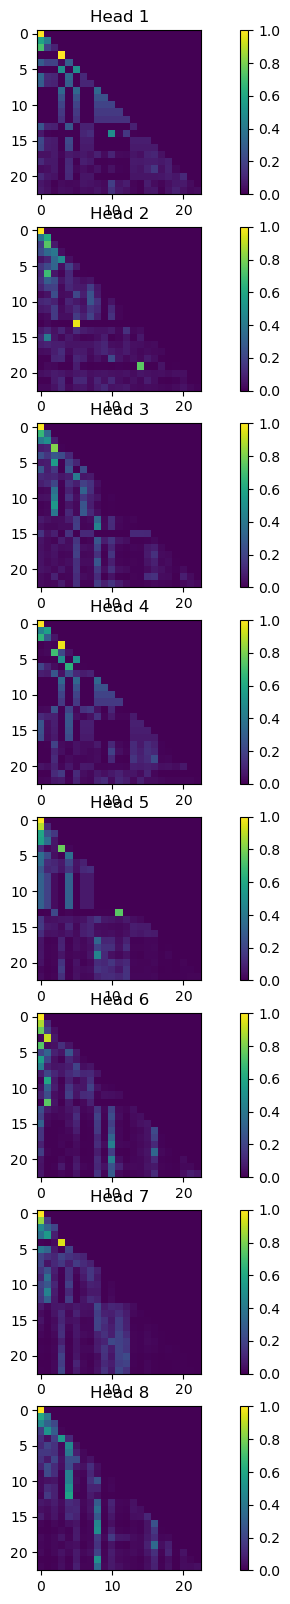

In [53]:
attn_view(attn_probs,attn_mask,item_seq_len,norm_to_probs=False)

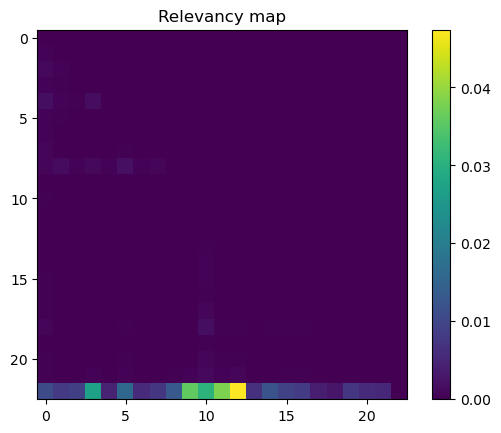

In [54]:
# show relevancy map
r = copy(rel_map.numpy()[:item_seq_len,:item_seq_len])
np.fill_diagonal(r,r.min(axis=1))
# denom=r.max(axis=-1)-r.min(axis=-1)+1e-9
# r=[r[i]/denom[i] for i in range(len(denom))]
fig, ax = plt.subplots()
im=ax.imshow(r, cmap='viridis', interpolation='nearest')
ax.set_title('Relevancy map')
# add colorbar to each plot
fig.colorbar(im, ax=ax)
plt.show()

### Manual Evaluation

In [ ]:
def analyze_interaction(interaction_idx, model, dataset, topk=20):
    interaction = dataset[interaction_idx:interaction_idx+1]
    item_seq = interaction[ITEM_SEQ].to(config['device'])
    item_seq_len = interaction[ITEM_SEQ_LEN].to(config['device'])
    gt_item = interaction[ITEM_ID]
    item_embeddings = model.item_embedding.weight
    seq_output=model(item_seq, item_seq_len)
    scores = torch.matmul(seq_output, item_embeddings.transpose(0, 1))  # [B, item_num]
    topk_scores, topk_items = torch.topk(scores, topk)
    
    return gt_item.detach().cpu().numpy(), topk_items.detach().cpu().numpy()




In [ ]:
gt_item, topk_items = analyze_interaction(13, model, test_dataset, topk=20)
gt_item in topk_items

In [ ]:
result=[gt in topk for gt, topk in [analyze_interaction(i, model, test_dataset, topk=10) for i in range(len(test_dataset))]]
# this should be equivalent to the recall@topk 
sum(result)/len(result)


### Evaluate using trainer

In [ ]:
from recbole.data import data_preparation

In [ ]:
train_data, valid_data, test_data = data_preparation(config, dataset)
test_data

In [ ]:
test_data.dataset

In [ ]:
interaction=test_data.dataset[13:14]
interaction.business_id_list

In [ ]:
# interaction, scores, positive_u, positive_i = eval_func(batched_data)
batched_data = next(test_data)

In [ ]:
batched_data[0].business_id_list[89]

In [ ]:
batched_data

In [ ]:
#create an instance of the model
model = get_model(config['model'])(config, dataset).to(config['device'])
model 

In [ ]:
# set model path
model_path=os.path.join(difsr_root,'saved/yelp_cat_L1')
os.listdir(model_path)

In [ ]:
# get trainer
trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)


In [ ]:
model_file_name=os.path.join(model_path,'SASRecD-Apr-09-2023_e150.pth')
test_result = trainer.evaluate(test_data,
                               load_best_model=True,
                               model_file = model_file_name,
                               show_progress=config['show_progress'])
test_result

In [ ]:
model_file_name=os.path.join(model_path,'SASRecD-Apr-09-2023_20-03-18.pth')
test_result = trainer.evaluate(test_data,
                               load_best_model=True,
                               model_file = model_file_name,
                               show_progress=config['show_progress'])
test_result